In [ ]:
#| hide
from CubicGalileonEmu.load import *

# CubicGalileonEmu

> GP emulator for boost factor in cubic Galileon gravity model

Modified Gravity emulator for boost in the dark matter power spectra

## Install

```sh
pip install CubicGalileonEmu
```

## How to use

A few imports 

In [ ]:
#| export

from CubicGalileonEmu.load import *
from CubicGalileonEmu.viz import *

In [ ]:
#| export

Bk_all, k_all, z_all = load_boost_training()
p_all = load_params()

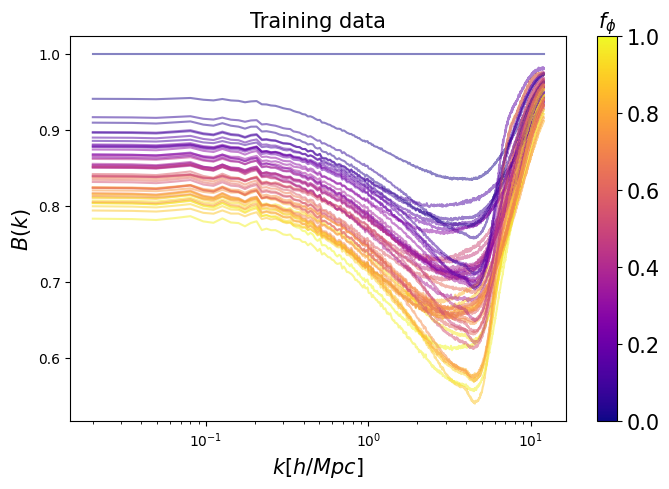

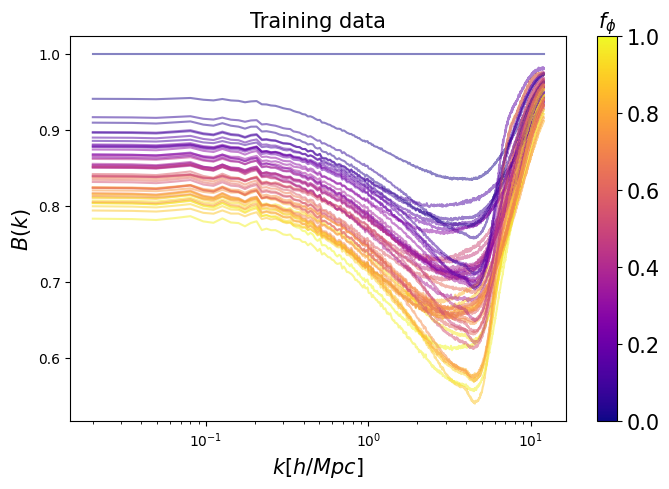

In [ ]:
#| export

color_by_index = 4
z_index = 35

plot_lines_with_param_color(p_all[:, color_by_index], 
                            k_all, 
                            Bk_all[:, z_index, :], 
                            'Training data', 
                            r'$k [h/Mpc]$', 
                            r'$B(k)$', 
                            PARAM_NAME[color_by_index])

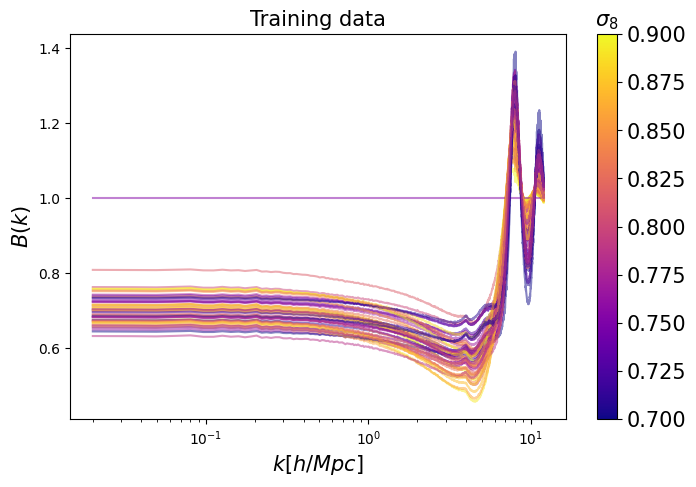

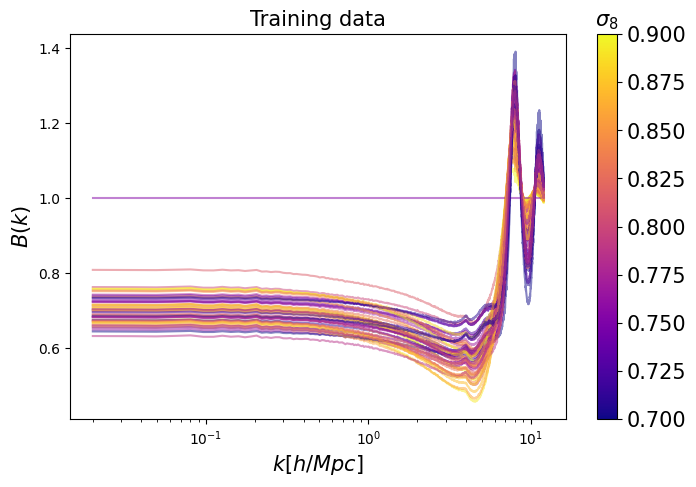

In [ ]:
#| export

color_by_index = 2
z_index = 45

plot_lines_with_param_color(p_all[:, color_by_index], 
                            k_all, 
                            Bk_all[:, z_index, :], 
                            'Training data', 
                            r'$k [h/Mpc]$', 
                            r'$B(k)$', 
                            PARAM_NAME[color_by_index])